### 1.Importing Necessary libraries

In [12]:
import pandas as pd
import numpy as np
import os
import pickle
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential,Model,load_model
from keras.layers import Embedding,Conv1D,MaxPooling1D
from keras.layers.core import Dense, Activation,Dropout ,Flatten, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence,one_hot,Tokenizer
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint,TensorBoard, ReduceLROnPlateau,EarlyStopping
from keras.applications import Xception
from keras import regularizers
from keras import backend as K
import keras
import numpy as np
import pandas as pd
import os
import glob
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from numpy import array
from numpy import asarray
from numpy import zeros

### 2. Initialize the seed inorder to get the same output every single time

In [13]:
seed = 120
np.random.seed(seed)

### 3. Loading the training data

In [14]:
train_path = 'D:/Software/01 Android Studio/Intent-classification/data/train/train_dataset.csv'
train_df = pd.read_csv(train_path, encoding = "latin-1")# Loading a csv file with headers
test_path = 'D:/Software/01 Android Studio/Intent-classification/data/train/val_dataset.csv'
test_df = pd.read_csv(test_path, encoding = "latin-1")

# Plot the data frame

In [4]:

def count_pandas(df):
    counts = [0] * len(labels)
    for index, data in df.iterrows():
        for label in labels:
            if data[label] > 0:
                counts[labels.index(label)] += 1
                continue
    return counts

performance = count_pandas(train_df)



[238463, 269660, 50607]


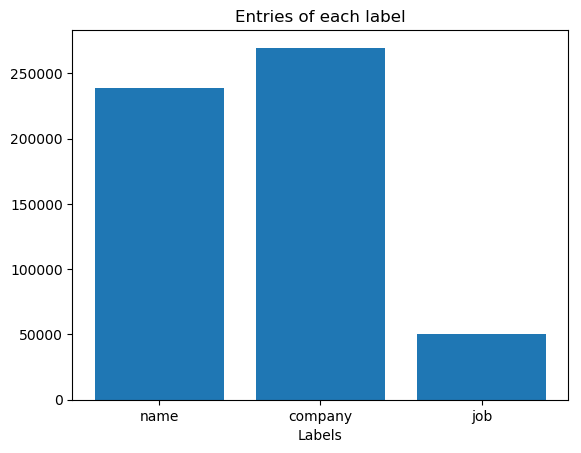

In [5]:
y_pos = np.arange(len(labels))

# Explore data
plt.rcdefaults()
fig, ax = plt.subplots()
print(performance)
ax.bar(labels, performance, align='center')
ax.set_xticks(y_pos)
ax.set_xticklabels(labels)

ax.set_xlabel('Labels')
ax.set_title('Entries of each label')

plt.show()

### 4. Shuffling the dataframe

In [15]:
labels = ["name", "company", "job"]
train_df = shuffle(train_df)
train_df.head()
test_df = shuffle(test_df)
test_df.head()

,sentence,name,company,job
25216,saiph,0,1,0
66086,police chief,0,0,1
99399,winnipeg hyundai,0,1,0
65437,nn group,0,1,0
47893,tana oy,0,1,0


### 4. Now saving the dataframe column(X_train,Y_train) as a numpy array

Here,
- X_train -> Its a feature(INPUT)
- Y_tain -> Its a label(OUTPUT)

In [16]:
X_train = train_df["sentence"].fillna("fillna").values
Y_train = train_df[labels].values
print(X_train[0])
print(Y_train[0])
X_val = test_df["sentence"].fillna("fillna").values
Y_val = test_df[labels].values
print(X_val[0])
print(Y_val[0])

rhoda dennis
[1 0 0]
saiph
[0 1 0]


In [17]:
print("Shape of X_train:",X_train.shape)
print("Shape of Y_train:",Y_train.shape)
print("Shape of X_test:",X_val.shape)
print("Shape of Y_test:",Y_val.shape)

Shape of X_train: (499979,)
Shape of Y_train: (499979, 3)
Shape of X_test: (106436,)
Shape of Y_test: (106436, 3)


### 7. Setting up Tokenizer class
The Tokenizer class in Keras has various methods which help to prepare text so it can be used in neural network models.

In [18]:
Tokenizer = Tokenizer()
print(X_train[0]) # training dataset 1st sentence
print(X_val[0])

rhoda dennis
saiph


In [19]:
texts = X_train
Tokenizer.fit_on_texts(texts) 
Tokenizer_vocab_size = len(Tokenizer.word_index) + 1
print("Tokenizer vocabulary size:",Tokenizer_vocab_size)
text2 = X_val
Tokenizer.fit_on_texts(text2) 
Tokenizer_vocab_size2 = len(Tokenizer.word_index) + 1
print("test- Tokenizer vocabulary size:",Tokenizer_vocab_size2)


Tokenizer vocabulary size: 204816
test- Tokenizer vocabulary size: 242950


### 8. Now find the length of longest sublist in X_train,X_test and set it as max Word Count

In [20]:
print((max(X_train, key=len)))
print((max(X_val, key=len)))

louisiana rehabilitation serviceslouisiana workforce commission
engineering organization leaderâsolutions architecture   implementation


In [21]:
maxWordCount= 5
maxDictionary_size=Tokenizer_vocab_size2

### 9. Now setting up data for validation and training:

In [22]:
# num_test_samples = 43585 # Test samples for validation


# # Phase 1: Setting up data for training
# X_train = X_train[num_test_samples:] # num_test_samples samples to n ----> Sentence (Input)
# Y_train = Y_train[num_test_samples:] # num_test_samples samples to n ----> Labels (Output)

# # Phase 2: Setting up data for validation
# X_val = X_train[:num_test_samples] # First num_test_samples Samples --> Sentence (Input)
# Y_val = Y_train[:num_test_samples] # First num_test_samples Samples --> Labels (Output)

In [23]:
print("(Input->Sentence) Length of X_train:",X_train.shape) # Input -> Input
print("(output->Labels) Length of Y_train:",Y_train.shape) # output -> Labels

(Input->Sentence) Length of X_train: (499979,)
(output->Labels) Length of Y_train: (499979, 3)


###  11.  Encoding Operation--->Turn text into a numerical array(using Tokenizer.texts_to_sequences)--->Uses Tokenizer_word_index.


In [24]:
# Phase 3: Encoding Operation--->Turn text into a numerical array(using Tokenizer.texts_to_sequences)--->Uses Tokenizer_word_index.
X_train_encoded_words = Tokenizer.texts_to_sequences(X_train)
X_val_encoded_words = Tokenizer.texts_to_sequences(X_val)

In [25]:
print("(output->Labels) Length of Y_train:",Y_train.shape) # output -> Labelsprint("(Input->Sentence) Length of X_train:",len(X_train_encoded_words)) # Input -> Input

(output->Labels) Length of Y_train: (499979, 3)


### 12. Padding all text to same size

In [26]:
X_train_encoded_padded_words = sequence.pad_sequences(X_train_encoded_words, maxlen=maxWordCount)
X_val_encoded_padded_words = sequence.pad_sequences(X_val_encoded_words, maxlen=maxWordCount)

In [27]:
print("(Input->Sentence) Length of X_train:",X_train_encoded_padded_words.shape) # Input -> Input
print("(output->Labels) Length of Y_train:",Y_train.shape) # output -> Labels

(Input->Sentence) Length of X_train: (499979, 5)
(output->Labels) Length of Y_train: (499979, 3)


In [28]:
print(Y_train.shape)
print(Y_val.shape)
embeddings_index = dict()
f = open('D:/UserProfile/Downloads/glove.6B/glove.6B.50d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((maxDictionary_size, 50))
not_include = 0
for word, i in Tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        not_include +=1
       

(499979, 3)
(106436, 3)
Loaded 400000 word vectors.


### 13. Now defining the neural network model

In [29]:
#model
model = Sequential()
model.add(Embedding(maxDictionary_size, 50, weights=[embedding_matrix], input_length=maxWordCount)) #to change words to ints
 #hidden layers
model.add(LSTM(512))
model.add(Dropout(0.6))
model.add(Dense(1200, activation='relu',W_constraint=maxnorm(1)))
model.add(Dense(500, activation='relu',W_constraint=maxnorm(1)))
 #output layer
model.add(Dense(3, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1200, activation="relu", kernel_constraint=<keras.con...)`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", kernel_constraint=<keras.con...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 50)             12147500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1153024   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1200)              615600    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               600500    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1503      
Total params: 14,518,127
Trainable params: 14,518,127
Non-trainable params: 0
________________________________________________________________

### 14. Now setting up learning rate,optimizers,batch_size, and compiling the model

In [33]:
learning_rate=0.0001
epochs = 5
batch_size = 32
adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [34]:
print(X_train_encoded_padded_words.shape)
print(Y_train.shape)

print(X_val_encoded_padded_words.shape)
print(Y_val.shape)

(499979, 5)
(499979, 3)
(106436, 5)
(106436, 3)


### 15. Training the model

In [35]:
# model.fit(Train_input,Train_output,epochs,batch_size,verbose,validation_data=(val_input,val_output))
history  = model.fit(X_train_encoded_padded_words,Y_train, epochs = epochs, batch_size=batch_size, shuffle=True, verbose=1,
                    validation_data=(X_val_encoded_padded_words, Y_val))

Train on 499979 samples, validate on 106436 samples
Epoch 1/5
499979/499979 [==============================] - 5122s 10ms/step - loss: 0.1123 - acc: 0.9637 - val_loss: 0.0950 - val_acc: 0.9700
Epoch 2/5
499979/499979 [==============================] - 5100s 10ms/step - loss: 0.0623 - acc: 0.9813 - val_loss: 0.0784 - val_acc: 0.9778
Epoch 3/5
499979/499979 [==============================] - 5268s 11ms/step - loss: 0.0421 - acc: 0.9873 - val_loss: 0.0670 - val_acc: 0.9812
Epoch 4/5
499979/499979 [==============================] - 3938s 8ms/step - loss: 0.0290 - acc: 0.9910 - val_loss: 0.0831 - val_acc: 0.9834
Epoch 5/5
499979/499979 [==============================] - 3122s 6ms/step - loss: 0.0217 - acc: 0.9935 - val_loss: 0.0657 - val_acc: 0.9850


### 16. Calculating the score

In [42]:
print("=============================== Score =========================================")
# Finally calucating the score.
score = model.evaluate(X_val_encoded_padded_words, Y_val, verbose=1)
print('Test accuracy:', score[1],'%')

=============================== Score =========================================
106436/106436 [==============================] - 40s 374us/step
Test accuracy: 0.9849862828366343 %


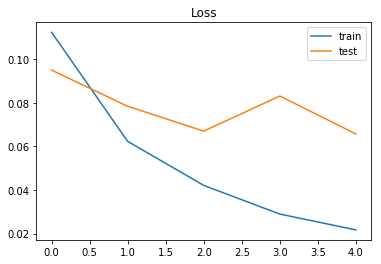

In [43]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

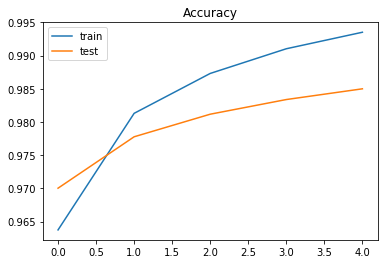

In [44]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

### 17. Predicting the text

In [48]:
phrase = "framas vietnam ltd"
tokens = Tokenizer.texts_to_sequences([phrase])
tokens = pad_sequences(tokens, maxlen=5)
print(tokens[0])
prediction = model.predict(np.array(tokens))
print("Shape of embeddings : ",prediction.shape)
i,j = np.where(prediction == prediction.max()) #calculates the index of the maximum element of the array across all axis
# i->rows, j->columns
i = int(i)
j = int(j)
print(prediction)
total_possible_outcomes = ["1_name", "2_company", "3_job"]
print("Result:",total_possible_outcomes[j])


[     0      0 236662   2243      1]
Shape of embeddings :  (1, 3)
[[1.80061989e-15 1.00000000e+00 1.45929056e-08]]
Result: 2_company


### 18. Saving your model to json and weights as HDF5 format

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("D:/Software/01 Android Studio/Intent-classification/data/train/model_final_new2.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("D:/Software/01 Android Studio/Intent-classification/data/train/model_final_new2.h5")
print("Saved model to disk")

Saved model to disk


### 19. Storing Tokenizer for storing

In [47]:
# saving
with open('D:/Software/01 Android Studio/Intent-classification/data/train/tokenizer_final_new2.pickle', 'wb') as handle:
    pickle.dump(Tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)